# Exp 011: Grammar Detection - Manual Corpus Search
This experiments uses regular expressions to identify possible positive and hard negative instances in multiple corpora. It may add handpicked generated examples if the corpus does not have enough examples.

In [12]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['CACHE_DIR'] = f"/scratch/tmp.{os.getenv('SLURM_JOB_ID')}.dglandorf" # speed up model loading

import re
import os
import random
import numpy as np
import json
from torch import tensor, Tensor
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.model_selection import KFold
from collections import defaultdict
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import sys
sys.path.append('../source')
import models
import data
import helpers
import importlib
#importlib.reload(data)

[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.1176827.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


<module 'data' from '/cluster/home/dglandorf/grammarctg/experiments/../source/data.py'>

In [18]:
# output dataset
output_path = '../data/detection/annotated_corpus.json'
instances = pd.DataFrame(columns=['#', 'sentence', 'positive'], dtype={'positive': bool}) if not os.path.exists(output_path) else pd.read_json(output_path)
instances['positive'] = instances['positive'].astype(bool)

metrics_path = "../data/detection/manual_training_metrics.json"
item_nrs = helpers.get_existing_classifiers('corpus_training')

num_tries = 3

In [13]:
# load corpus sentences and prepare dataloader
sentences = data.get_mixed_sentences(10000, corpora = [data.DailyDialog, data.DialogSum, data.WoW], shuffle=True)
egp_gpt = pd.read_json("../data/egp_gpt35.json")

# initialize corpus to check against
max_batches = 64
batch_size = 256
encoded_inputs = models.bert_tokenizer(sentences[:12*max_batches*batch_size], return_tensors='pt', max_length=64, padding='max_length', truncation=True)
encoded_inputs['sentences'] = sentences[:12*max_batches*batch_size]
corpus_dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
corpus_dataloader = DataLoader(corpus_dataset, batch_size=batch_size, shuffle=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.75s/it]


In [3]:
# manipulation functions for instance dataset
def get_positives(instances, nr):
    return list(instances[(instances['#'] == nr) & instances['positive']]['sentence'])
def get_negatives(instances, nr):
    return list(instances[(instances['#'] == nr) & ~instances['positive']]['sentence'])
def get_others(sentences, matches):
    return list(set(sentences).difference(set(matches)))
def add_to_instances(sentences, nr, positive=True):
    global instances
    if isinstance(sentences, list):
        for sentence in sentences:
            new_row = pd.DataFrame({'#': [nr], 'sentence': [sentence], 'positive': [positive]})
            instances = pd.concat([instances, new_row], ignore_index=True)
    else:
        new_row = pd.DataFrame({'#': [nr], 'sentence': [sentences], 'positive': [positive]})
        instances = pd.concat([instances, new_row], ignore_index=True)
    instances.to_json(output_path)

# model training
def get_trained_classifer(positive, negative, others, classifier=models.RuleDetector(models.bert_encoder).to(models.device), ratio=1, verbose=True):
    dataset = data.get_dataset(positive, negative, others, models.bert_tokenizer, 64, ratio*len(positive)/len(negative), verbose=verbose) 
    train_dataloader, val_dataloader = data.get_loaders(dataset)
    _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, num_epochs=None, verbose=verbose)
    return classifier, val_metrics

Find examples for would rules (616-638), superlatives (1105-1131), negations (1175-1205)

In [144]:
nr = 637

In [146]:
pattern = r"would (strongly|easily|especially|actually|gladly)"
matches = [sentence for sentence in sentences if re.search(pattern, sentence, re.IGNORECASE)]
random.shuffle(matches)
candidates = iter(matches)

In [157]:
gpt35 = egp_gpt.loc[nr-1]
egp_matches = gpt35['augmented_examples']
random.shuffle(egp_matches)
candidates = iter(egp_matches)

In [122]:
anti_pattern =  r" possible "
anti_matches = [sentence for sentence in sentences if re.search(anti_pattern, sentence, re.IGNORECASE)]
random.shuffle(anti_matches)
candidates = iter(anti_matches)

In [30]:
candidates = iter(get_positives(instances, nr))

In [167]:
while 1==1:
    if len(get_positives(instances, nr)) == 50: print("** REACHED 50 POSITIVES **")
    try:
        candidate = next(candidates)
    except StopIteration:
        print("No candidates left.")
        break
    if candidate in list(instances[instances['#'] == nr]['sentence']): continue # prevent duplicates
    #candidate = candidate.replace(",", "")
    user_response = input(f"{candidate}")
    if user_response == "c": break
    if user_response == "s": continue
    if user_response == "del": 
        instances = instances.iloc[:-1]
        continue
    new_row = pd.DataFrame({'#': [nr], 'sentence': [candidate], 'positive': [True if user_response == '2' else False]})
    instances = pd.concat([instances, new_row], ignore_index=True)
    instances.to_json(output_path)

What happens if we make a deal and thirty to sixty days after delivery the price goes down and you didn't get the best possible price? 1
Speaking of chores, I would rather do some washing than cooking. 2
We always try to serve our guests in the most agreeable way possible. 1
Since you're growing steadily, I would be very eager to help you to improve your accounting system. 1
You can rest assured that we'll do everything possible to prevent de festive commodities from going abroad. 1
And then the next hour, I would help you with your Chinese. 1
I would select the individual that has the most qualifications among all the applicants. 1
It may well be that the goods would be ordered to be destroyed. 1
Well, first of all, I would be able to teach them everything they learn in school in a more relaxed and fun way. 1
If your aim is to use the account the same way as your use your Settlement Account, I would recommend the Type A Account for you. 1
I would recommend we scrap this one and you br

In [36]:
#instances = instances.iloc[:-1]

In [148]:
get_positives(instances, nr)

["I would actually love to be able to see the one in Hawaii, it's actually a hotspot also and it's postulated that the lava there is coming from the core-mantle boundary 3000km deep",
 'Wow that is really interesting i never thought they would actually breed the horses for the comercials haha',
 'Well that would actually be cheating because a vegan you would have to refrain from consuming animal products, not only meat but also eggs, dairy products and other animal-derived substances',
 'Housewarming parties get their name from the fact that a long time ago people would actually bring firewood to a new home as a gift.',
 "It's around 2200 miles long, even doing 50 miles walking a day (a full day of walking) it would easily take one person months.",
 "That's from the 1890's when ragtime player would actually duel to see who was better.",
 'I would strongly recommend you put fresh vegetables in your sandwich.',
 "I haven't but I would absolutely love to.",
 'I would absolutely love to go

In [168]:
print(f'Positive: {len(get_positives(instances, nr))}, Negative: {len(get_negatives(instances, nr))}')

Positive: 135, Negative: 282


In [170]:
classifier, val_metrics = get_trained_classifer(get_positives(instances, nr), get_negatives(instances, nr), get_others(sentences, matches), ratio=3, verbose=False)
val_metrics

386


 20%|███████████████████████████                                                                                                            | 2/10 [00:02<00:11,  1.49s/it]


{'accuracy': 0.951, 'f1': 0.847, 'precision': 0.915}

Check on entire corpus

In [ ]:
# shuffle inputs
shuffled_index = np.random.permutation(encoded_inputs['input_ids'].size(0))
for key, value in encoded_inputs.items():
    encoded_inputs[key] = value[shuffled_index] if isinstance(value, Tensor) else [value[i] for i in shuffled_index]
batch_size = 256
num_examples = 64000
corpus_dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
corpus_dataloader = DataLoader(corpus_dataset, batch_size=batch_size, shuffle=False)
scores, tokens = models.score_corpus(classifier, corpus_dataloader, max_positive=25, max_batches=num_examples//batch_size, threshold=0.5)
results = list(zip(scores, tokens, encoded_inputs['sentences'][:len(scores)]))
subset = [(score, token, sample) for score, token, sample in results if
     score > 0.5 and not sample in get_positives(instances, nr)]
subset_sentences = [sample for _, _, sample in subset]
candidates = iter(subset_sentences) 
subset_sentences

 25%|████████████████████████████████▊                                                                                                   | 191/768 [01:00<30:35,  3.18s/it]

Sanity check on EGP examples

In [130]:
candidates = gpt35['Example'].split("\n\n")
models.probe_model(classifier, candidates)

(tensor([0.9890, 0.9887, 0.9863]), ['possible', 'possible', 'possible'])

In [131]:
models.save_classifier(classifier, nr, "corpus_training")

In [21]:
#nr=619
#classifier = models.load_classifier(nr, "corpus_training")

## Evaluation
Strategy: Track F1 score on validation set and precision in novel corpora sentences

In [17]:
existing_nrs = helpers.get_existing_classifiers()
egp = helpers.get_egp()

In [19]:
total_folds = 5
batch_size = 32
metrics = {}

for nr in existing_nrs:
    print(f'#{nr}')
    pos = get_positives(instances, nr)
    neg = get_negatives(instances, nr)
    
    dataset = data.get_dataset(pos, neg, get_others(sentences, pos), models.bert_tokenizer, 64, 3*len(pos)/len(neg))
    indices = list(range(len(dataset)))
    kf = KFold(n_splits=total_folds, shuffle=True, random_state=26)
    accumulated_metrics = defaultdict(list)
    for fold_index in tqdm(range(total_folds)):
        train_indices, val_indices = list(kf.split(indices))[fold_index]
        train_dataloader = DataLoader(Subset(dataset, train_indices), batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(Subset(dataset, val_indices), batch_size=batch_size, shuffle=False)

        for i in range(num_tries):
            classifier=models.RuleDetector(models.bert_encoder).to(models.device)
            _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, num_epochs=None, verbose=False, leave=False)
            for metric_name, metric_value in val_metrics.items():
                accumulated_metrics[metric_name].append(metric_value)
    
    average_metrics = {metric_name: sum(metric_values) / len(metric_values) for metric_name, metric_values in accumulated_metrics.items()}
    metrics[nr] = average_metrics
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)
    print(average_metrics)

#616


  0%|          | 0/5 [00:00<?, ?it/s]


 13%|█████████████▋                                                                                           | 13/100 [00:09<01:01,  1.42it/s]
                                                                                                                                               
 12%|████████████▌                                                                                            | 12/100 [00:08<01:03,  1.39it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:06<01:09,  1.30it/s]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:04<01:19,  1

{'accuracy': 0.9561333333333334, 'f1': 0.8312666666666667, 'precision': 0.8348666666666668}
#617


  0%|          | 0/5 [00:00<?, ?it/s]


 12%|████████████▌                                                                                            | 12/100 [00:11<01:21,  1.08it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:08<01:25,  1.07it/s]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:07<01:25,  1.08it/s]
                                                                                                                                               
 12%|████████████▌                                                                                            | 12/100 [00:11<01:22,  1

{'accuracy': 0.9601999999999999, 'f1': 0.88, 'precision': 0.8615999999999999}
#618


  0%|          | 0/5 [00:00<?, ?it/s]


  4%|████▏                                                                                                     | 4/100 [00:04<01:45,  1.10s/it]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:05<01:33,  1.00it/s]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:04<01:31,  1.04it/s]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:08<01:34,  1

{'accuracy': 0.9564666666666665, 'f1': 0.8986666666666667, 'precision': 0.8287333333333334}
#619


  0%|          | 0/5 [00:00<?, ?it/s]


  4%|████▏                                                                                                     | 4/100 [00:02<01:03,  1.52it/s]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:04<00:57,  1.61it/s]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:05<00:57,  1.61it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:04<00:57,  1

{'accuracy': 0.9136000000000001, 'f1': 0.7854666666666666, 'precision': 0.8108000000000001}
#620


  0%|          | 0/5 [00:00<?, ?it/s]


  6%|██████▎                                                                                                   | 6/100 [00:04<01:10,  1.33it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:05<01:09,  1.33it/s]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:05<01:08,  1.34it/s]
                                                                                                                                               
 12%|████████████▌                                                                                            | 12/100 [00:08<01:05,  1

{'accuracy': 0.9558000000000001, 'f1': 0.7588666666666666, 'precision': 0.8126666666666666}
#621


  0%|          | 0/5 [00:00<?, ?it/s]


  5%|█████▎                                                                                                    | 5/100 [00:02<00:49,  1.92it/s]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:02<00:50,  1.90it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:10<01:51,  1.24s/it]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:03<00:56,  1

{'accuracy': 0.9187333333333335, 'f1': 0.6553333333333332, 'precision': 0.5984}
#622


  0%|          | 0/5 [00:00<?, ?it/s]


  8%|████████▍                                                                                                 | 8/100 [00:08<01:45,  1.15s/it]
                                                                                                                                               
  2%|██                                                                                                        | 2/100 [00:02<01:44,  1.06s/it]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:06<01:41,  1.08s/it]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:08<02:35,  1

{'accuracy': 0.9432000000000001, 'f1': 0.4864666666666667, 'precision': 0.502}
#623


  0%|          | 0/5 [00:00<?, ?it/s]


  8%|████████▍                                                                                                 | 8/100 [00:02<00:27,  3.31it/s]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:02<00:26,  3.48it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:02<00:26,  3.38it/s]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:01<00:27,  3

{'accuracy': 0.8814000000000001, 'f1': 0.0296, 'precision': 0.06666666666666667}
#624


  0%|          | 0/5 [00:00<?, ?it/s]


 13%|█████████████▋                                                                                           | 13/100 [00:06<00:44,  1.95it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:03<00:48,  1.91it/s]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:02<00:51,  1.86it/s]
                                                                                                                                               
 11%|███████████▌                                                                                             | 11/100 [00:05<00:46,  1

{'accuracy': 0.9763333333333334, 'f1': 0.9374000000000001, 'precision': 0.9085333333333334}
#625


  0%|          | 0/5 [00:00<?, ?it/s]


  3%|███▏                                                                                                      | 3/100 [00:01<01:03,  1.53it/s]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:04<01:02,  1.49it/s]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:03<01:02,  1.51it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:04<01:02,  1

{'accuracy': 0.9158666666666666, 'f1': 0.6696666666666667, 'precision': 0.7694}
#626


  0%|          | 0/5 [00:00<?, ?it/s]


  9%|█████████▌                                                                                                | 9/100 [00:04<00:47,  1.91it/s]
                                                                                                                                               
 11%|███████████▌                                                                                             | 11/100 [00:05<00:46,  1.93it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:05<00:49,  1.83it/s]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:04<00:47,  1

{'accuracy': 0.9689333333333334, 'f1': 0.9267333333333333, 'precision': 0.8655333333333334}
#627


  0%|          | 0/5 [00:00<?, ?it/s]


  9%|█████████▌                                                                                                | 9/100 [00:05<00:54,  1.68it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:06<00:54,  1.64it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:06<00:56,  1.59it/s]
                                                                                                                                               
 11%|███████████▌                                                                                             | 11/100 [00:06<00:53,  1

{'accuracy': 0.9481333333333335, 'f1': 0.8337333333333332, 'precision': 0.8161999999999999}
#628


  0%|          | 0/5 [00:00<?, ?it/s]


  9%|█████████▌                                                                                                | 9/100 [00:16<03:04,  2.03s/it]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:23<05:56,  3.80s/it]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:13<02:39,  1.74s/it]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:11<02:34,  1

{'accuracy': 0.9674, 'f1': 0.8398666666666668, 'precision': 0.9423333333333336}
#629


  0%|          | 0/5 [00:00<?, ?it/s]


  8%|████████▍                                                                                                 | 8/100 [00:07<01:33,  1.02s/it]
                                                                                                                                               
  2%|██                                                                                                        | 2/100 [00:01<01:33,  1.05it/s]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:05<01:29,  1.05it/s]
                                                                                                                                               
 12%|████████████▌                                                                                            | 12/100 [00:11<01:24,  1

{'accuracy': 0.9090666666666665, 'f1': 0.4042666666666667, 'precision': 0.42286666666666667}
#637


  0%|          | 0/5 [00:00<?, ?it/s]


  6%|██████▎                                                                                                   | 6/100 [00:07<02:04,  1.32s/it]
                                                                                                                                               
  4%|████▏                                                                                                     | 4/100 [00:05<02:12,  1.38s/it]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:08<02:07,  1.36s/it]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:13<02:00,  1

{'accuracy': 0.9176666666666666, 'f1': 0.7291333333333333, 'precision': 0.8397333333333333}
#638


  0%|          | 0/5 [00:00<?, ?it/s]


  4%|████▏                                                                                                     | 4/100 [00:02<01:05,  1.47it/s]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:04<01:06,  1.42it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:06<01:02,  1.46it/s]
                                                                                                                                               
  4%|████▏                                                                                                     | 4/100 [00:02<01:05,  1

{'accuracy': 0.8996000000000001, 'f1': 0.0222, 'precision': 0.06666666666666667}
#630


  0%|          | 0/5 [00:00<?, ?it/s]


  4%|████▏                                                                                                     | 4/100 [00:08<03:15,  2.04s/it]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:10<03:15,  2.06s/it]
                                                                                                                                               
  4%|████▏                                                                                                     | 4/100 [00:08<03:14,  2.03s/it]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:10<03:22,  2

{'accuracy': 0.9856666666666667, 'f1': 0.9635333333333336, 'precision': 0.9540666666666665}
#631


  0%|          | 0/5 [00:00<?, ?it/s]


  6%|██████▎                                                                                                   | 6/100 [00:05<01:30,  1.04it/s]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:04<01:31,  1.03it/s]
                                                                                                                                               
  4%|████▏                                                                                                     | 4/100 [00:03<01:32,  1.04it/s]
                                                                                                                                               
  4%|████▏                                                                                                     | 4/100 [00:03<01:32,  1

{'accuracy': 0.9710000000000001, 'f1': 0.9261999999999999, 'precision': 0.9082000000000001}
#632


  0%|          | 0/5 [00:00<?, ?it/s]


 10%|██████████▌                                                                                              | 10/100 [00:04<00:41,  2.19it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:03<00:40,  2.25it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:04<00:40,  2.25it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:03<00:41,  2

{'accuracy': 0.9769333333333334, 'f1': 0.9418000000000001, 'precision': 0.9322}
#633


  0%|          | 0/5 [00:00<?, ?it/s]


  9%|█████████▌                                                                                                | 9/100 [00:04<00:46,  1.94it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:05<00:44,  2.01it/s]
                                                                                                                                               
 11%|███████████▌                                                                                             | 11/100 [00:05<00:45,  1.98it/s]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:02<00:46,  2

{'accuracy': 0.9176, 'f1': 0.6885333333333334, 'precision': 0.6938666666666666}
#634


  0%|          | 0/5 [00:00<?, ?it/s]


  9%|█████████▌                                                                                                | 9/100 [00:05<00:59,  1.52it/s]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:04<00:54,  1.70it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:05<00:53,  1.68it/s]
                                                                                                                                               
 12%|████████████▌                                                                                            | 12/100 [00:07<00:51,  1

{'accuracy': 0.9, 'f1': 0.6744666666666668, 'precision': 0.6605333333333332}
#635


  0%|          | 0/5 [00:00<?, ?it/s]


 12%|████████████▌                                                                                            | 12/100 [00:06<00:45,  1.93it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:05<00:45,  1.98it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:04<00:46,  1.96it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:05<00:46,  1

{'accuracy': 0.9556, 'f1': 0.8365333333333332, 'precision': 0.8546}
#636


  0%|          | 0/5 [00:00<?, ?it/s]


  6%|██████▎                                                                                                   | 6/100 [00:07<02:01,  1.29s/it]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:11<01:59,  1.32s/it]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:09<02:02,  1.32s/it]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:09<02:04,  1

{'accuracy': 0.9812666666666666, 'f1': 0.9536666666666668, 'precision': 0.9524000000000001}
#1175


  0%|          | 0/5 [00:00<?, ?it/s]


  7%|███████▍                                                                                                  | 7/100 [00:04<01:04,  1.44it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:06<00:57,  1.58it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:05<00:57,  1.58it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:06<00:56,  1

{'accuracy': 0.9478000000000001, 'f1': 0.8805333333333331, 'precision': 0.8412}
#1176


  0%|          | 0/5 [00:00<?, ?it/s]


  6%|██████▎                                                                                                   | 6/100 [00:04<01:04,  1.45it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:04<01:02,  1.49it/s]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:03<01:03,  1.50it/s]
                                                                                                                                               
  4%|████▏                                                                                                     | 4/100 [00:02<01:05,  1

{'accuracy': 0.9136000000000001, 'f1': 0.7812, 'precision': 0.7972}
#1177


  0%|          | 0/5 [00:00<?, ?it/s]


  5%|█████▎                                                                                                    | 5/100 [00:03<01:02,  1.52it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:06<00:58,  1.54it/s]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:03<01:03,  1.51it/s]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:05<01:00,  1

{'accuracy': 0.9548, 'f1': 0.9200666666666667, 'precision': 0.9176666666666669}
#1178


  0%|          | 0/5 [00:00<?, ?it/s]


  7%|███████▍                                                                                                  | 7/100 [00:08<01:50,  1.19s/it]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:09<01:45,  1.15s/it]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:07<01:51,  1.19s/it]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:06<01:47,  1

{'accuracy': 0.9355999999999999, 'f1': 0.8596666666666667, 'precision': 0.8388000000000001}
#1179


  0%|          | 0/5 [00:00<?, ?it/s]


  4%|████▏                                                                                                     | 4/100 [00:04<01:37,  1.02s/it]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:06<01:37,  1.03s/it]
                                                                                                                                               
  4%|████▏                                                                                                     | 4/100 [00:04<01:38,  1.03s/it]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:08<01:34,  1

{'accuracy': 0.9820666666666666, 'f1': 0.9644, 'precision': 0.9443333333333332}
#1180


  0%|          | 0/5 [00:00<?, ?it/s]


  7%|███████▍                                                                                                  | 7/100 [00:06<01:17,  1.20it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:05<01:16,  1.21it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:05<01:18,  1.18it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:05<01:16,  1

{'accuracy': 0.9920000000000001, 'f1': 0.9811333333333335, 'precision': 0.9677333333333333}
#1185


  0%|          | 0/5 [00:00<?, ?it/s]


  5%|█████▎                                                                                                    | 5/100 [00:05<01:48,  1.15s/it]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:05<01:56,  1.23s/it]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:05<01:49,  1.15s/it]
                                                                                                                                               
  4%|████▏                                                                                                     | 4/100 [00:04<01:50,  1

{'accuracy': 0.9591333333333332, 'f1': 0.9026000000000001, 'precision': 0.8848666666666669}
#1186


  0%|          | 0/5 [00:00<?, ?it/s]


  4%|████▏                                                                                                     | 4/100 [00:05<02:19,  1.46s/it]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:12<02:20,  1.52s/it]
                                                                                                                                               
  2%|██                                                                                                        | 2/100 [00:02<02:23,  1.47s/it]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:10<02:16,  1

{'accuracy': 0.9290666666666668, 'f1': 0.8347333333333334, 'precision': 0.8437999999999999}
#1187


  0%|          | 0/5 [00:00<?, ?it/s]


  4%|████▏                                                                                                     | 4/100 [00:04<01:39,  1.03s/it]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:06<01:37,  1.03s/it]
                                                                                                                                               
  4%|████▏                                                                                                     | 4/100 [00:04<01:40,  1.05s/it]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:07<01:37,  1

{'accuracy': 0.9893333333333335, 'f1': 0.9761333333333333, 'precision': 0.9746666666666667}
#1192


  0%|          | 0/5 [00:00<?, ?it/s]


  9%|█████████▌                                                                                                | 9/100 [00:05<00:59,  1.53it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:06<01:00,  1.49it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:05<00:59,  1.54it/s]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:05<01:00,  1

{'accuracy': 0.9064000000000002, 'f1': 0.6650000000000001, 'precision': 0.6990666666666667}
#1193


  0%|          | 0/5 [00:00<?, ?it/s]


 17%|█████████████████▊                                                                                       | 17/100 [00:04<00:22,  3.73it/s]
                                                                                                                                               
 19%|███████████████████▉                                                                                     | 19/100 [00:05<00:21,  3.73it/s]
                                                                                                                                               
 16%|████████████████▊                                                                                        | 16/100 [00:04<00:28,  2.97it/s]
                                                                                                                                               
 13%|█████████████▋                                                                                           | 13/100 [00:03<00:23,  3

{'accuracy': 0.9229333333333334, 'f1': 0.7990666666666665, 'precision': 0.8443333333333333}
#1194


  0%|          | 0/5 [00:00<?, ?it/s]


  9%|█████████▌                                                                                                | 9/100 [00:02<00:28,  3.19it/s]
                                                                                                                                               
 17%|█████████████████▊                                                                                       | 17/100 [00:05<00:26,  3.19it/s]
                                                                                                                                               
 17%|█████████████████▊                                                                                       | 17/100 [00:05<00:26,  3.13it/s]
                                                                                                                                               
 11%|███████████▌                                                                                             | 11/100 [00:03<00:27,  3

{'accuracy': 0.9694666666666667, 'f1': 0.9377333333333333, 'precision': 0.9818}
#1196


  0%|          | 0/5 [00:00<?, ?it/s]


  4%|████▏                                                                                                     | 4/100 [00:02<00:54,  1.75it/s]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:03<00:52,  1.78it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:03<00:51,  1.80it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:05<00:49,  1

{'accuracy': 0.9024666666666666, 'f1': 0.5218666666666667, 'precision': 0.6533333333333334}
#1197


  0%|          | 0/5 [00:00<?, ?it/s]


 15%|███████████████▊                                                                                         | 15/100 [00:07<00:42,  1.98it/s]
                                                                                                                                               
 12%|████████████▌                                                                                            | 12/100 [00:06<00:44,  1.97it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:04<00:47,  1.91it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:05<00:45,  1

{'accuracy': 0.9843333333333334, 'f1': 0.9572666666666667, 'precision': 0.9466}
#1198


  0%|          | 0/5 [00:00<?, ?it/s]


 12%|████████████▌                                                                                            | 12/100 [00:04<00:35,  2.49it/s]
                                                                                                                                               
 17%|█████████████████▊                                                                                       | 17/100 [00:06<00:32,  2.55it/s]
                                                                                                                                               
 11%|███████████▌                                                                                             | 11/100 [00:04<00:34,  2.56it/s]
                                                                                                                                               
 11%|███████████▌                                                                                             | 11/100 [00:04<00:35,  2

{'accuracy': 0.9912, 'f1': 0.9808, 'precision': 0.9910666666666667}
#1202


  0%|          | 0/5 [00:00<?, ?it/s]


 12%|████████████▌                                                                                            | 12/100 [00:05<00:41,  2.13it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:04<00:40,  2.21it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:04<00:41,  2.18it/s]
                                                                                                                                               
 13%|█████████████▋                                                                                           | 13/100 [00:05<00:39,  2

{'accuracy': 0.9727999999999998, 'f1': 0.9127333333333336, 'precision': 0.9434000000000001}
#1203


  0%|          | 0/5 [00:00<?, ?it/s]


 10%|██████████▌                                                                                              | 10/100 [00:03<00:32,  2.79it/s]
                                                                                                                                               
 11%|███████████▌                                                                                             | 11/100 [00:03<00:32,  2.72it/s]
                                                                                                                                               
 12%|████████████▌                                                                                            | 12/100 [00:04<00:31,  2.82it/s]
                                                                                                                                               
 13%|█████████████▋                                                                                           | 13/100 [00:04<00:31,  2

{'accuracy': 0.9619333333333332, 'f1': 0.8445333333333335, 'precision': 0.9122}
#1204


  0%|          | 0/5 [00:00<?, ?it/s]


 19%|███████████████████▉                                                                                     | 19/100 [00:07<00:32,  2.53it/s]
                                                                                                                                               
 15%|███████████████▊                                                                                         | 15/100 [00:05<00:33,  2.52it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:03<00:35,  2.54it/s]
                                                                                                                                               
 17%|█████████████████▊                                                                                       | 17/100 [00:06<00:33,  2

{'accuracy': 0.9943333333333334, 'f1': 0.9884000000000001, 'precision': 0.9777333333333333}
#57


  0%|          | 0/5 [00:00<?, ?it/s]


  8%|████████▍                                                                                                 | 8/100 [00:09<01:52,  1.22s/it]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:09<01:43,  1.13s/it]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:10<01:41,  1.11s/it]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:05<01:45,  1

{'accuracy': 0.9760666666666665, 'f1': 0.9457999999999999, 'precision': 0.9048666666666666}
#58


  0%|          | 0/5 [00:00<?, ?it/s]


  8%|████████▍                                                                                                 | 8/100 [00:04<00:46,  1.96it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:04<00:45,  1.98it/s]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:03<00:49,  1.89it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:04<00:46,  1

{'accuracy': 0.9375333333333332, 'f1': 0.8664666666666669, 'precision': 0.8301999999999999}
#70


  0%|          | 0/5 [00:00<?, ?it/s]


  7%|███████▍                                                                                                  | 7/100 [00:03<00:41,  2.26it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:03<00:40,  2.27it/s]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:03<00:40,  2.25it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:03<00:40,  2

{'accuracy': 0.9722666666666666, 'f1': 0.9334666666666666, 'precision': 0.926}
#75


  0%|          | 0/5 [00:00<?, ?it/s]


 14%|██████████████▋                                                                                          | 14/100 [00:06<00:37,  2.29it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:04<00:39,  2.30it/s]
                                                                                                                                               
 13%|█████████████▋                                                                                           | 13/100 [00:05<00:37,  2.31it/s]
                                                                                                                                               
 15%|███████████████▊                                                                                         | 15/100 [00:06<00:37,  2

{'accuracy': 0.9288666666666666, 'f1': 0.7669333333333334, 'precision': 0.9119333333333334}
#77


  0%|          | 0/5 [00:00<?, ?it/s]


 11%|███████████▌                                                                                             | 11/100 [00:07<01:03,  1.41it/s]
                                                                                                                                               
 15%|███████████████▊                                                                                         | 15/100 [00:10<00:59,  1.43it/s]
                                                                                                                                               
 14%|██████████████▋                                                                                          | 14/100 [00:09<01:00,  1.42it/s]
                                                                                                                                               
 12%|████████████▌                                                                                            | 12/100 [00:08<01:02,  1

{'accuracy': 0.9269333333333332, 'f1': 0.7388000000000001, 'precision': 0.8598666666666667}
#79


  0%|          | 0/5 [00:00<?, ?it/s]


 12%|████████████▌                                                                                            | 12/100 [00:03<00:24,  3.53it/s]
                                                                                                                                               
 16%|████████████████▊                                                                                        | 16/100 [00:04<00:24,  3.45it/s]
                                                                                                                                               
 10%|██████████▌                                                                                              | 10/100 [00:02<00:26,  3.43it/s]
                                                                                                                                               
 19%|███████████████████▉                                                                                     | 19/100 [00:05<00:23,  3

{'accuracy': 0.9859333333333333, 'f1': 0.9475999999999999, 'precision': 0.94}
#59


  0%|          | 0/5 [00:00<?, ?it/s]


  5%|█████▎                                                                                                    | 5/100 [00:05<01:41,  1.07s/it]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:07<01:45,  1.13s/it]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:08<01:38,  1.08s/it]
                                                                                                                                               
  4%|████▏                                                                                                     | 4/100 [00:04<01:45,  1

{'accuracy': 0.9516000000000001, 'f1': 0.8889333333333332, 'precision': 0.8383333333333332}
#60


  0%|          | 0/5 [00:00<?, ?it/s]


  7%|███████▍                                                                                                  | 7/100 [00:10<02:25,  1.56s/it]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:07<02:34,  1.62s/it]
                                                                                                                                               
  4%|████▏                                                                                                     | 4/100 [00:05<02:21,  1.47s/it]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:09<02:31,  1

{'accuracy': 0.9404, 'f1': 0.8586000000000003, 'precision': 0.8556666666666667}
#69


  0%|          | 0/5 [00:00<?, ?it/s]


  8%|████████▍                                                                                                 | 8/100 [00:06<01:14,  1.23it/s]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:04<01:15,  1.25it/s]
                                                                                                                                               
  6%|██████▎                                                                                                   | 6/100 [00:04<01:14,  1.25it/s]
                                                                                                                                               
 11%|███████████▌                                                                                             | 11/100 [00:09<01:13,  1

{'accuracy': 0.8998666666666666, 'f1': 0.7586666666666667, 'precision': 0.7565999999999999}
#71


  0%|          | 0/5 [00:00<?, ?it/s]


 10%|██████████▌                                                                                              | 10/100 [00:04<00:35,  2.52it/s]
                                                                                                                                               
 13%|█████████████▋                                                                                           | 13/100 [00:05<00:34,  2.52it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:03<00:37,  2.41it/s]
                                                                                                                                               
  9%|█████████▌                                                                                                | 9/100 [00:03<00:36,  2

{'accuracy': 0.9604, 'f1': 0.8997999999999998, 'precision': 0.8512000000000001}
#74


  0%|          | 0/5 [00:00<?, ?it/s]


  6%|██████▎                                                                                                   | 6/100 [00:04<01:19,  1.19it/s]
                                                                                                                                               
  5%|█████▎                                                                                                    | 5/100 [00:03<01:13,  1.29it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:05<01:09,  1.33it/s]
                                                                                                                                               
  8%|████████▍                                                                                                 | 8/100 [00:06<01:13,  1

{'accuracy': 0.9722000000000002, 'f1': 0.9182666666666666, 'precision': 0.9349333333333334}
#76


  0%|          | 0/5 [00:00<?, ?it/s]


  8%|████████▍                                                                                                 | 8/100 [00:07<01:28,  1.03it/s]
                                                                                                                                               
  4%|████▏                                                                                                     | 4/100 [00:03<01:33,  1.03it/s]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:09<02:29,  1.61s/it]
                                                                                                                                               
  7%|███████▍                                                                                                  | 7/100 [00:06<01:32,  1

{'accuracy': 0.9527333333333333, 'f1': 0.8958, 'precision': 0.8482666666666667}


In [28]:
# check on examples
for nr in existing_nrs:
    classifier = models.load_classifier(nr, "corpus_training")
    rule = egp[egp['#']==nr].iloc[0]
    examples = rule['Example'].split("\n\n")
    print(rule['Can-do statement'])
    print(((models.probe_model(classifier, examples)[0]>0.5).sum()/len(examples)).item())

Can use the affirmative form with 'like'. 
1.0
Can use 'would like to invite' to make invitations.
1.0
Can use 'would like' to talk about wishes and preferences.
1.0
Can use the affirmative form.
1.0
Can use the negative forms.
1.0
Can use the question form 'would you like'.
1.0
Can use 'would' to talk about imagined situations.
0.5
Can use 'it would be' to make suggestions.
0.3333333432674408
Can use 'would' with a wide range of verbs to talk about wishes and preferences.
1.0
Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.
1.0
Can use 'would have' + '-ed'.
1.0
Can use 'would not have' + '-ed' or 'wouldn’t have' + '-ed'
1.0
Can use question forms.
0.75
Can use an limited range of adverbs with 'would', including 'really', 'probably', 'certainly', 'definitely'.► adverbs
1.0
Can use an increasing range of adverbs with 'would', including 'strongly', 'easily', 'especially', 'actually', 'absol

## Manual classifier corpus validation

In [80]:
# config
hits_path = '../data/corpus_validation_hits.json'
max_batches = 1000
batch_size = 256
min_probes = 20

Set up validation data

In [81]:
test_sentences = data.get_mixed_sentences(int(1e9), corpora=[data.CMUDoG, data.ToC])
random.shuffle(test_sentences)

test_inputs = models.bert_tokenizer(test_sentences[:max_batches*batch_size], return_tensors='pt', max_length=64, padding='max_length', truncation=True)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.68s/it]


In [132]:
existing_nrs=[77]

In [136]:
coded_instances = pd.DataFrame(columns=['#', 'sentence', 'correct', 'score', 'max_token']) if not os.path.exists(hits_path) else pd.read_json(hits_path)
coded_instances['correct'] = coded_instances['correct'].astype(bool)

In [138]:
coded_instances = coded_instances[coded_instances['#']!=77]
len(coded_instances)

In [140]:
for nr in existing_nrs:
    rule = egp[egp['#']==nr].iloc[0]
    if len(coded_instances[coded_instances['#']==nr]) >= min_probes: continue
    print(f"#{nr}: {rule['Type']}: {rule['Can-do statement']} ({rule['SuperCategory']}: {rule['SubCategory']})")
    print(rule['Example'])
    classifier = models.load_classifier(nr, "corpus_training", parallel=True)

    scores, tokens = models.score_corpus(classifier, test_dataloader, max_positive=25, max_batches=max_batches)
    hits = [(score, token, sample) for score, token, sample in zip(scores, tokens, test_sentences[:len(scores)]) if score > 0.5]
    for score, token, sample in hits[:20]:
        if sample in list(coded_instances[coded_instances['#']==nr]['sentence']): continue
        user_response = input(f"{sample}")
        new_row = pd.DataFrame({'#': [nr],
             'sentence': [sample],
             'correct': [user_response == '2'],
             'score': [score],
             'max_token': [token]})
        coded_instances = pd.concat([coded_instances, new_row], ignore_index=True)
    coded_instances.to_json(hits_path)

#77: FORM/USE: Can use a postmodifier to make the superlative stronger in the structure superlative + postmodifier + noun.  (ADJECTIVES: superlatives)
What is more, in order to increase sales of the new model to the highest possible level, the possibility of entering the Asian markets should be considered. 

I am fond of the idea of working in Central London. It absolutely is the best possible location , I cannot deny that. 

It is not the shortest possible route, but the easiest for people with luggage.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:16<00:00,  7.30it/s]


Their love would be keeping them together in the most tragic way possible. 2
I would think that is the only possible idea unless we get mystical. 2
If you're paying millions of dollars, I would definitely shoot in the most optimal way possible haha. 2
They are constantly updating and trying to give customers the best service possible and correct any bugs. 2
There is an annual literature contest that challenges writers to come up with the worst possible opening sentence. 2
You would think the parties would have figured that out by now, and that people would be trying to elect the tallest possible candidate in the primaries. 2
I wonder if he ever entered the annual literature contest that challenges writers to come up with the worst possible opening to a novel. 2
Edgar Allen Poe wrote the oldest known example of a cyborg! 2
It is the only known astronomical object to harbor life 2
i think that the fans want to see the best players possible. 2
Did you know that there is an annual literatu

### Analysis of corpus validation

In [141]:
with open(metrics_path, 'r') as f:
    metrics = json.load(f)
coded_instances = pd.read_json(hits_path)
counts = coded_instances.groupby('#').size()
correct_per_rule = coded_instances[coded_instances['#'].isin(counts[counts > 5].index)].groupby('#')['correct'].mean()

In [142]:
correct_per_rule[correct_per_rule>=.8].index

Int64Index([  57,   58,   59,   69,   76,   77,  616,  618,  619,  621,  624,
             625,  628,  629,  630,  631,  634,  635,  636, 1112, 1116, 1175,
            1176, 1177, 1178, 1179, 1187, 1192, 1197, 1198],
           dtype='int64', name='#')

In [143]:
egp.loc[correct_per_rule[correct_per_rule>=.8].index-1].groupby(["Level","SubCategory"])['#'].agg("count")

Level  SubCategory 
A1     negation        3
       superlatives    1
       would           2
A2     negation        2
       superlatives    2
       would           3
B1     conditional     2
       negation        1
       superlatives    1
       would           7
B2     negation        1
       superlatives    1
       would           1
C1     negation        2
       superlatives    1
Name: #, dtype: int64

In [92]:
corrects = pd.DataFrame(correct_per_rule).reset_index()
corrects['Level'] = egp['Level'].loc[corrects['#']-1].reset_index(drop=True)

In [93]:
corrects

,#,correct,Level
0,57,0.960000,A1
1,58,0.800000,A2
2,59,0.800000,A2
3,60,0.750000,A2
4,69,1.000000,B1
5,70,0.500000,B1
6,71,0.200000,B1
7,74,0.000000,B2
8,75,0.684211,B2
9,76,0.800000,B2


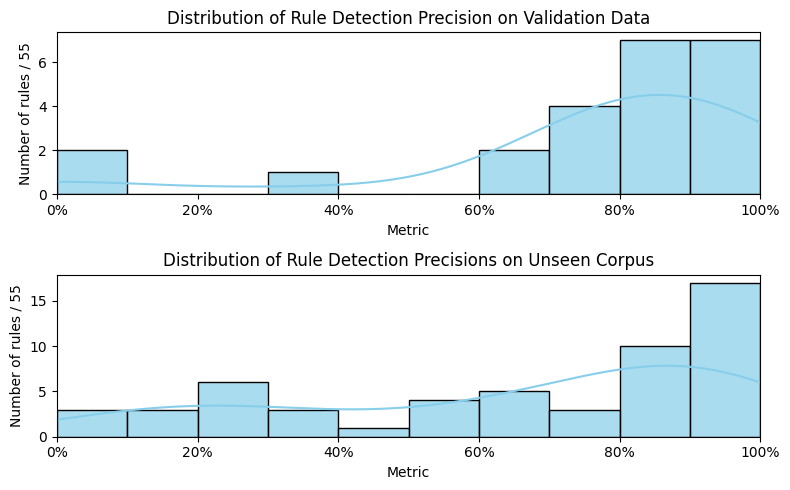

In [25]:
def plot_histogram(ax, data):
    sns.histplot(ax=ax, data=data, bins=10, kde=True, color="skyblue", edgecolor='black', alpha=0.7, legend=False)
    ax.set_ylabel(f"Number of rules / {len(correct_per_rule)}")
    ax.set_xlabel("Metric")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    ax.set_xlim(0, 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 5))
plot_histogram(axs[0], [m['precision'] for m in metrics.values()])
axs[0].set_title("Distribution of Rule Detection Precision on Validation Data")
plot_histogram(axs[1], list(correct_per_rule))
axs[1].set_title("Distribution of Rule Detection Precisions on Unseen Corpus")
plt.tight_layout()
plt.show()

In [19]:
corpus_instances = [np.mean([m['precision'] for m in metrics.values()]), correct_per_rule.mean()]

In [20]:
corpus_instances

[0.7550173913043479, 0.6870175146490934]

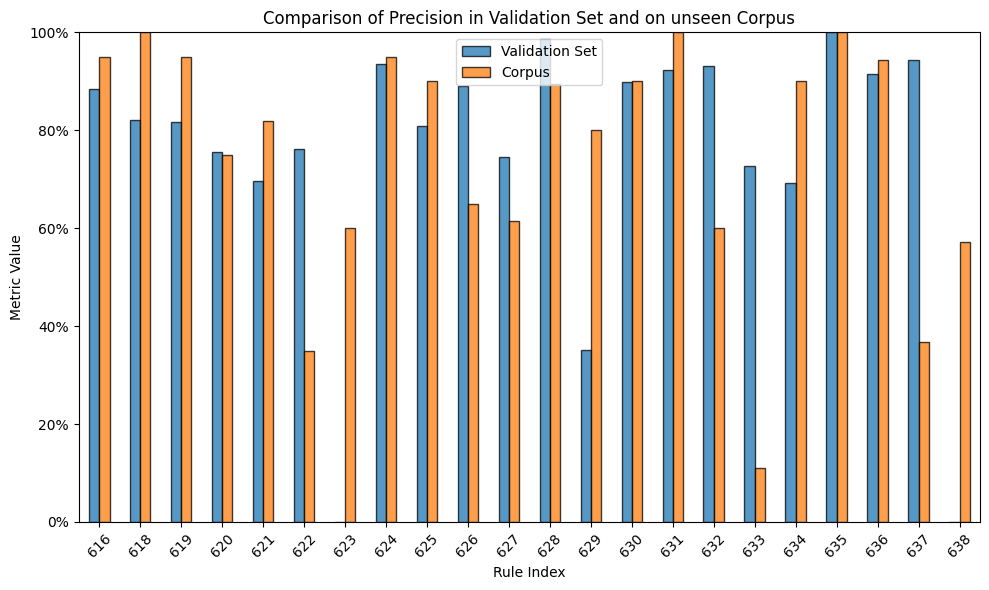

In [78]:
df = pd.DataFrame({'Validation Set': [m['precision'] for m in metrics.values()], 'Corpus': list(correct_per_rule)})
ax = df.plot(kind='bar', figsize=(10, 6), alpha=0.75, edgecolor='black')
ax.set_xlabel("Rule Index")
ax.set_ylabel("Metric Value")
ax.set_title("Comparison of Precision in Validation Set and on unseen Corpus")
ax.set_xticklabels(correct_per_rule.index, rotation=45)
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

plt.tight_layout()
plt.show()